In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn import preprocessing

In [2]:
from Data_interpret.GroundTruth import ReadMat
from pathlib import Path
import sys

In [3]:
# Loading data
data_dir = './Raw_data/8_8_2019 to 8_12_2019/'
fname1 = data_dir + '2019-08-08-19-16-02_5sec.mat'
fname2 = data_dir + '2019-08-09-12-49-56_7sec.mat'
fname3 = data_dir + '2019-08-09-13-01-42_10sec.mat'

train_data = ReadMat(fname1)
train_data2 = ReadMat(fname3)
test_data = ReadMat(fname2)

# Sampling data
sample_size = 100  # sampling of raw data
train_state_traj, train_action_traj = train_data.sampled_mocap_data(sample_size)  # state X time, number of actions X time
train_state_traj2, train_action_traj2 = train_data2.sampled_mocap_data(sample_size)  # state X time, number of actions X time
test_state_traj, test_action_traj = test_data.sampled_mocap_data(sample_size)

In [4]:
print("train_shape",train_state_traj.shape,"train_action_shape", train_action_traj.shape)
print("train2_shape",train_state_traj2.shape,"train2_action_shape", train_action_traj2.shape)
print("test_shape",test_state_traj.shape,"test_action_traj", test_action_traj.shape)
train_sa1 = np.concatenate((train_state_traj,train_action_traj),axis=0)# train state action trajecctory
train_sa2 = np.concatenate((train_state_traj2,train_action_traj2),axis=0)## train state action trajecctory2
test_sa = np.concatenate((test_state_traj,test_action_traj),axis=0)# test state action trajecctory

train_shape (9, 553) train_action_shape (3, 553)
train2_shape (9, 1056) train2_action_shape (3, 1056)
test_shape (9, 756) test_action_traj (3, 756)


In [14]:
class RoboFlyDataset(torch.utils.data.Dataset):
    def __init__(self, Data_chunks, sequence_length, batch_size,transform=None):
        super(RoboFlyDataset, self).__init__()
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        
        assert self.batch_size == Data_chunks.shape[0]
        self.n = Data_chunks.shape[0]*Data_chunks.shape[1] #total timesteps
        self.dataset,self.labels= self.generate_data_labels(Data_chunks)
        # TODO: Any preprocessing on the data to get it to the right shape.
        self.time_steps_in_a_batch = self.batch_size*self.sequence_length
        self.no_of_batches = np.floor(self.n / (self.time_steps_in_a_batch)).astype('int')
              
    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of time steps.
        return self.no_of_batches * self.batch_size
    
    def generate_data_labels(self,Data_chunks):
        for i in range(Data_chunks.shape[0]):
            if i==0:
                dataset= Data_chunks[i,:-1]
                labels= Data_chunks[i,1:,0:9]
                #assert dataset.shape==labels.shape
            else:
                data= Data_chunks[i,:-1]
                label= Data_chunks[i,1:,0:9]
                #assert data.shape==label.shape
                dataset= np.concatenate((dataset,data),axis=0)
                labels= np.concatenate((labels,label),axis=0)
        print('datset_size',dataset.shape,labels.shape)
        return dataset,labels
        
    def __getitem__(self, idx):
        # Return the data and label for a time sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        location= idx*self.sequence_length
        numpy_data= self.dataset[location:location+self.sequence_length][:]
        data= torch.FloatTensor(numpy_data)
        label= torch.FloatTensor(self.labels[location:location+self.sequence_length][:])
        return (data,label)

In [15]:
class LSTMRoboflyNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTMRoboflyNet, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # Encoder
        self.fc1 = nn.Linear(self.input_size, 50)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 50)
        
        self.LSTM = nn.LSTM(50, 100, num_layers=2, batch_first=True)
        
        # Decoder
        self.fc3 = nn.Linear(100, 50)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(50, self.output_size)

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x, h = self.LSTM(x.view(batch_size,sequence_length,-1), hidden_state)
        x = self.fc3(x)
        x = self.relu2(x)
        x = self.fc4(x)

        return x

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        #print('MSE',prediction.view(-1, self.output_size).size(),label.view(-1,self.output_size).size())
        loss_val = nn.MSELoss(reduction=reduction)(prediction, label)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [160]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

check_data=[]
check_label=[]

def train(model, device, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    #init0 = torch.FloatTensor(init_states)
    #cell = torch.zeros((init0.size()))
    #hidden= (init0,cell)
    hidden = None
    for batch_idx, (data, label) in enumerate(train_loader):    
        data, label = data.to(device), label.to(device)
        check_data.append(data[0])
        check_label.append(label)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output = model(data, hidden)
        #pred = output.max(-1)[1]
        #print('train',output.size(),label.size())
        loss = model.loss(output, label)
        
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        if batch_idx % log_interval == 0:
            #print(data.size(),label.size())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        #init0 = torch.FloatTensor(init_state)
        #cell = torch.zeros((init0.size()))
        #hidden= (init0,cell)
        hidden = None
        all_output=[]
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            all_output.append(output)
#             pred = output
#             correct_mask = pred.eq(label.view_as(pred))
#             num_correct = correct_mask.sum().item()
#             correct += num_correct
#             # Comment this out to avoid printing test results
#             if batch_idx % 10 == 0:
#                 print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
#                     train_loader.dataset.vocab.array_to_words(data[0]),
#                     train_loader.dataset.vocab.array_to_words(label[0]),
#                     train_loader.dataset.vocab.array_to_words(pred[0])))
            
    test_loss /= len(test_loader)
    #test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}'.format(test_loss))
    return test_loss,all_output

In [161]:
#defining parameters
SEQUENCE_LENGTH = 20
BATCH_SIZE = 3
TEST_BATCH_SIZE = 1
EPOCHS = 2000 # going through the whole data how many times
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005
USE_CUDA = True
PRINT_INTERVAL = 20
LOG_PATH = 'logs/log.pkl'
input_size= 12
output_size= 9

In [162]:
# Normalize Training Data
chunk1 = train_sa1[:,25:526] #(12, 501) cutting 0.25 seconds from beginning
chunk2 = train_sa2[:,25:526] #(12, 501) cutting 0.25 seconds from beginning
chunk3 = train_sa2[:,526:1027] #(12, 501) cutting 0.25 seconds from beginning
data_chunks = preprocessing.scale(np.concatenate((chunk1, chunk2, chunk3), axis=1), axis=1) # 0 mean 1 var
data_chunks = np.array(np.split(data_chunks.T, 3)) # [3 x 501 x 12]

In [163]:
# Test Data
temp_test= test_sa.T
test_chunk= temp_test[25:725,:]
test_chunk.shape
test_data_chunk = preprocessing.scale(test_chunk, axis=0)
test_data_chunk = test_chunk.reshape((TEST_BATCH_SIZE,-1,12))

In [164]:
# data set objects
data_train = RoboFlyDataset(data_chunks, SEQUENCE_LENGTH, BATCH_SIZE)
data_test = RoboFlyDataset(test_data_chunk, SEQUENCE_LENGTH, TEST_BATCH_SIZE)

device = torch.device("cuda")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)
kwargs = {'num_workers': num_workers,
          'pin_memory': True}


#data loader objects
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

datset_size (1500, 12) (1500, 9)
datset_size (699, 12) (699, 9)
Using device cuda
num workers: 4


In [21]:
test_loader.__iter__()

In [165]:
model = LSTMRoboflyNet(input_size, output_size).to(device)
#model.load_state_dict(weights)

In [ ]:
#model definition
#model.load_state_dict(weights)

In [166]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = 0#model.load_last_model(DATA_PATH + 'checkpoints')
#parameters for tracking losses
train_losses=[]; test_losses=[]
#train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss,output = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))


try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss,output= test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    model.save_model('checkpoints/%03d.pt' % epoch, 0)


Test set: Average loss: 1.5009
Train Epoch: 0 [0/75 (0%)]	Loss: 2.102319
Train Epoch: 0 [60/75 (80%)]	Loss: 0.927571

Test set: Average loss: 1.4934
Train Epoch: 1 [0/75 (0%)]	Loss: 2.039384
Train Epoch: 1 [60/75 (80%)]	Loss: 0.625843

Test set: Average loss: 1.7776
Train Epoch: 2 [0/75 (0%)]	Loss: 1.865008
Train Epoch: 2 [60/75 (80%)]	Loss: 0.427840

Test set: Average loss: 1.6130
Train Epoch: 3 [0/75 (0%)]	Loss: 1.748687
Train Epoch: 3 [60/75 (80%)]	Loss: 0.331573

Test set: Average loss: 1.5606
Train Epoch: 4 [0/75 (0%)]	Loss: 1.755110
Train Epoch: 4 [60/75 (80%)]	Loss: 0.225475

Test set: Average loss: 1.4940
Train Epoch: 5 [0/75 (0%)]	Loss: 1.691359
Train Epoch: 5 [60/75 (80%)]	Loss: 0.176541

Test set: Average loss: 1.6695
Train Epoch: 6 [0/75 (0%)]	Loss: 1.671138
Train Epoch: 6 [60/75 (80%)]	Loss: 0.137854

Test set: Average loss: 1.5195
Train Epoch: 7 [0/75 (0%)]	Loss: 1.523590
Train Epoch: 7 [60/75 (80%)]	Loss: 0.158750

Test set: Average loss: 1.5763
Train Epoch: 8 [0/75 (0%


Test set: Average loss: 1.2560
Train Epoch: 69 [0/75 (0%)]	Loss: 0.100032
Train Epoch: 69 [60/75 (80%)]	Loss: 0.048823

Test set: Average loss: 0.8749
Train Epoch: 70 [0/75 (0%)]	Loss: 0.088521
Train Epoch: 70 [60/75 (80%)]	Loss: 0.048263

Test set: Average loss: 1.3173
Train Epoch: 71 [0/75 (0%)]	Loss: 0.139134
Train Epoch: 71 [60/75 (80%)]	Loss: 0.039396

Test set: Average loss: 1.1094
Train Epoch: 72 [0/75 (0%)]	Loss: 0.107870
Train Epoch: 72 [60/75 (80%)]	Loss: 0.042990

Test set: Average loss: 1.1406
Train Epoch: 73 [0/75 (0%)]	Loss: 0.113552
Train Epoch: 73 [60/75 (80%)]	Loss: 0.034949

Test set: Average loss: 1.0623
Train Epoch: 74 [0/75 (0%)]	Loss: 0.093921
Train Epoch: 74 [60/75 (80%)]	Loss: 0.041899

Test set: Average loss: 1.1909
Train Epoch: 75 [0/75 (0%)]	Loss: 0.098911
Train Epoch: 75 [60/75 (80%)]	Loss: 0.038287

Test set: Average loss: 1.0673
Train Epoch: 76 [0/75 (0%)]	Loss: 0.184722
Train Epoch: 76 [60/75 (80%)]	Loss: 0.042193

Test set: Average loss: 1.2743
Train Ep


Test set: Average loss: 0.9634
Train Epoch: 137 [0/75 (0%)]	Loss: 0.092443
Train Epoch: 137 [60/75 (80%)]	Loss: 0.036309

Test set: Average loss: 1.1248
Train Epoch: 138 [0/75 (0%)]	Loss: 0.061305
Train Epoch: 138 [60/75 (80%)]	Loss: 0.032585

Test set: Average loss: 0.8629
Train Epoch: 139 [0/75 (0%)]	Loss: 0.066157
Train Epoch: 139 [60/75 (80%)]	Loss: 0.032371

Test set: Average loss: 1.0164
Train Epoch: 140 [0/75 (0%)]	Loss: 0.178960
Train Epoch: 140 [60/75 (80%)]	Loss: 0.032849

Test set: Average loss: 0.8999
Train Epoch: 141 [0/75 (0%)]	Loss: 0.089846
Train Epoch: 141 [60/75 (80%)]	Loss: 0.026704

Test set: Average loss: 1.0334
Train Epoch: 142 [0/75 (0%)]	Loss: 0.158114
Train Epoch: 142 [60/75 (80%)]	Loss: 0.034326

Test set: Average loss: 0.9917
Train Epoch: 143 [0/75 (0%)]	Loss: 0.128089
Train Epoch: 143 [60/75 (80%)]	Loss: 0.036322

Test set: Average loss: 1.0885
Train Epoch: 144 [0/75 (0%)]	Loss: 0.116086
Train Epoch: 144 [60/75 (80%)]	Loss: 0.026468

Test set: Average loss:

Train Epoch: 204 [0/75 (0%)]	Loss: 0.063207
Train Epoch: 204 [60/75 (80%)]	Loss: 0.037109

Test set: Average loss: 0.8406
Train Epoch: 205 [0/75 (0%)]	Loss: 0.110647
Train Epoch: 205 [60/75 (80%)]	Loss: 0.023165

Test set: Average loss: 1.0338
Train Epoch: 206 [0/75 (0%)]	Loss: 0.116196
Train Epoch: 206 [60/75 (80%)]	Loss: 0.033119

Test set: Average loss: 0.8442
Train Epoch: 207 [0/75 (0%)]	Loss: 0.088783
Train Epoch: 207 [60/75 (80%)]	Loss: 0.028004

Test set: Average loss: 0.8479
Train Epoch: 208 [0/75 (0%)]	Loss: 0.093480
Train Epoch: 208 [60/75 (80%)]	Loss: 0.028269

Test set: Average loss: 0.8490
Train Epoch: 209 [0/75 (0%)]	Loss: 0.102842
Train Epoch: 209 [60/75 (80%)]	Loss: 0.024606

Test set: Average loss: 0.7834
Train Epoch: 210 [0/75 (0%)]	Loss: 0.110783
Train Epoch: 210 [60/75 (80%)]	Loss: 0.027327

Test set: Average loss: 0.9696
Train Epoch: 211 [0/75 (0%)]	Loss: 0.105339
Train Epoch: 211 [60/75 (80%)]	Loss: 0.020919

Test set: Average loss: 0.8850
Train Epoch: 212 [0/75 (


Test set: Average loss: 0.8469
Train Epoch: 272 [0/75 (0%)]	Loss: 0.062042
Train Epoch: 272 [60/75 (80%)]	Loss: 0.019865

Test set: Average loss: 0.8777
Train Epoch: 273 [0/75 (0%)]	Loss: 0.072706
Train Epoch: 273 [60/75 (80%)]	Loss: 0.024809

Test set: Average loss: 0.8894
Train Epoch: 274 [0/75 (0%)]	Loss: 0.055827
Train Epoch: 274 [60/75 (80%)]	Loss: 0.024667

Test set: Average loss: 0.9040
Train Epoch: 275 [0/75 (0%)]	Loss: 0.058204
Train Epoch: 275 [60/75 (80%)]	Loss: 0.024655

Test set: Average loss: 0.9133
Train Epoch: 276 [0/75 (0%)]	Loss: 0.077774
Train Epoch: 276 [60/75 (80%)]	Loss: 0.027692

Test set: Average loss: 0.9615
Train Epoch: 277 [0/75 (0%)]	Loss: 0.070103
Train Epoch: 277 [60/75 (80%)]	Loss: 0.025821

Test set: Average loss: 0.8112
Train Epoch: 278 [0/75 (0%)]	Loss: 0.036840
Train Epoch: 278 [60/75 (80%)]	Loss: 0.022124

Test set: Average loss: 0.9261
Train Epoch: 279 [0/75 (0%)]	Loss: 0.071584
Train Epoch: 279 [60/75 (80%)]	Loss: 0.021512

Test set: Average loss:

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f06b8340a70>
Traceback (most recent call last):
  File "/home/jasonx1e/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/jasonx1e/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/jasonx1e/anaconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/jasonx1e/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/jasonx1e/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


NameError: name 'pt_util' is not defined

In [136]:
# Model weights
weights = model.state_dict()

## Rolling Out (only 1 Step)

In [206]:
# Test
data_eval = RoboFlyDataset(test_data_chunk, 700, TEST_BATCH_SIZE)
eval_loader = torch.utils.data.DataLoader(data_eval, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

_, eval_batch_outputs = test(model, device, eval_loader)

datset_size (699, 12) (699, 9)

Test set: Average loss: 0.9226


In [207]:
for i in range(len(eval_batch_outputs)):
    eval_batch_outputs[i] = eval_batch_outputs[i].cpu().numpy()

eval_batch_outputs = np.stack(eval_batch_outputs)
eval_batch_outputs = np.squeeze(eval_batch_outputs)
eval_batch_outputs = eval_batch_outputs.reshape(-1, 9)

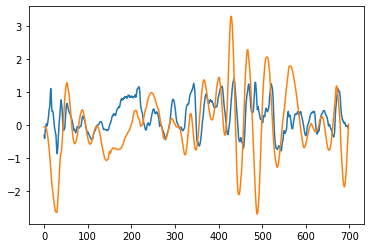

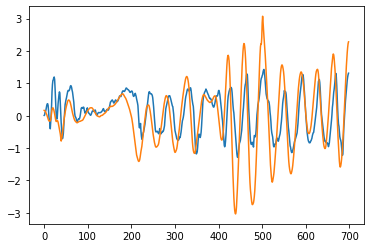

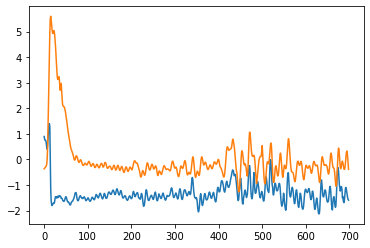

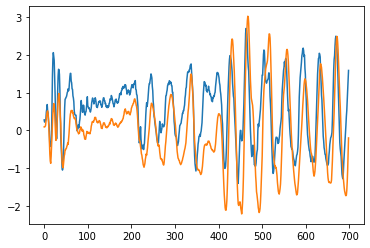

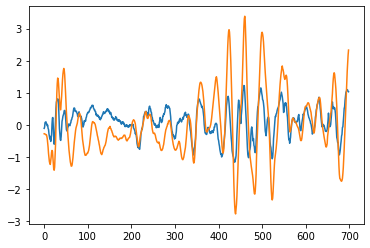

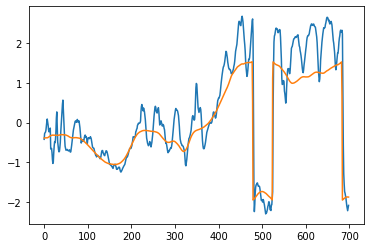

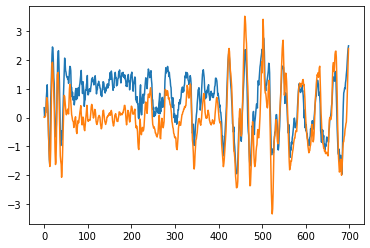

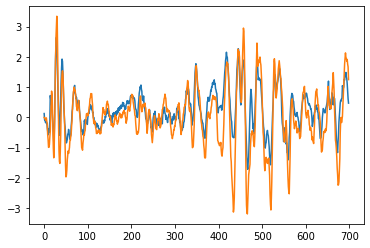

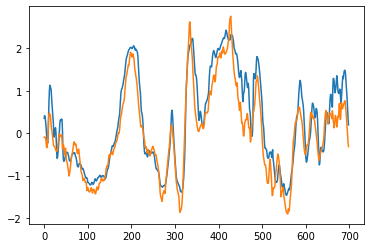

In [209]:
for i in range(9):
    plt.figure()
    plt.plot(eval_batch_outputs[:,i])
    plt.plot(preprocessing.scale(test_chunk[1:,i], axis=0)) # Normalized
    plt.plot()

## Rolling Out from Scratch

In [211]:
# Test
data_eval = RoboFlyDataset(test_data_chunk, 700, TEST_BATCH_SIZE)
eval_loader = torch.utils.data.DataLoader(data_eval, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)
eval_iter = eval_loader.__iter__()

eval_batch_inputs, eval_batch_targets = next(eval_iter)

datset_size (699, 12) (699, 9)


In [216]:
eval_batch_init = eval_batch_inputs[:,0].unsqueeze(1)
eval_batch_actions = eval_batch_inputs[:,1:,9:] # Actions from 1...TEST_BATCH_SIZE
eval_batch_outputs = [eval_batch_inputs[:,0,:9].unsqueeze(1)]

In [217]:
data = eval_batch_inputs[:,0].unsqueeze(1)
label = eval_batch_targets[:,0].unsqueeze(1)
for i in range(eval_batch_actions.shape[1]):
    label = eval_batch_targets[:,i].unsqueeze(1)
    
    model.eval()
    with torch.no_grad():
        hidden = None
        all_output=[]
        data, label = data.to(device), label.to(device)
        output = model(data, hidden)
        eval_batch_outputs.append(output)
        # test_loss += model.loss(output, label, reduction='mean').item()
        # all_output.append(output)
    
    next_action = eval_batch_actions[:,0,:].unsqueeze(1).cuda()
    data = torch.cat((output, next_action), dim=2)

In [218]:
for i in range(len(eval_batch_outputs)):
    eval_batch_outputs[i] = eval_batch_outputs[i].cpu().numpy()

eval_batch_outputs = np.stack(eval_batch_outputs)
eval_batch_outputs = np.squeeze(eval_batch_outputs)
eval_batch_outputs = eval_batch_outputs.reshape(-1, 9)

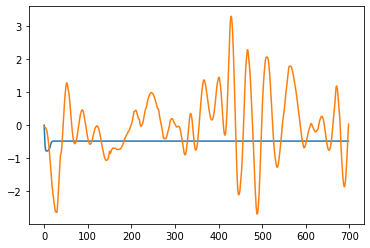

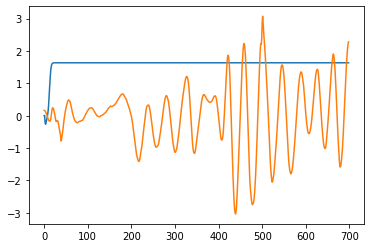

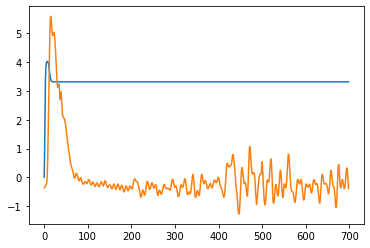

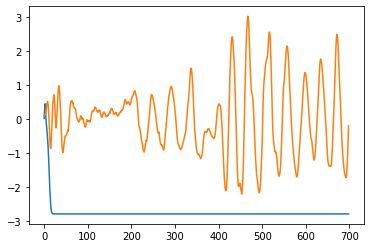

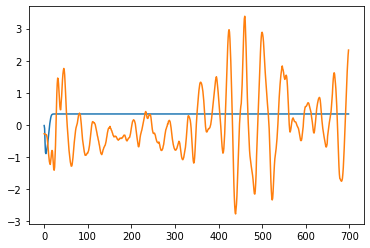

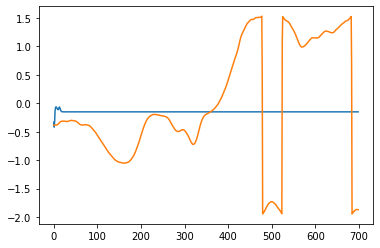

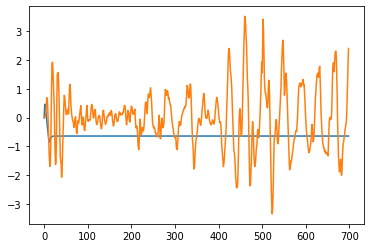

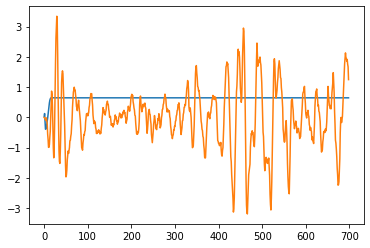

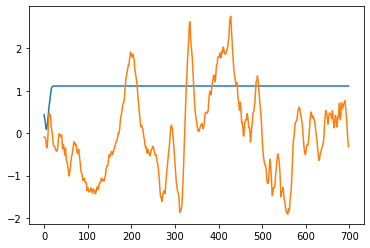

In [219]:
for i in range(9):
    plt.figure()
    plt.plot(eval_batch_outputs[:,i])
    plt.plot(preprocessing.scale(test_chunk[1:,i], axis=0)) # Normalized
    plt.plot()